# Image In-painting with Conditional Flow Matching (March 29th, 2025)

## Dataset

In [ ]:
!gdown -cq 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

In [ ]:
!wsl unzip celeba_hq_256.zip

In [ ]:
import glob

img_paths = glob.glob('./celeba_hq_256/*.*')
len(img_paths)

30000

In [ ]:
import torch

# dataset_size = len(img_paths)
# train_size = int(dataset_size * 0.9)
# val_size = dataset_size - train_size

train_img_paths, val_img_paths = torch.utils.data.random_split(img_paths, [0.9, 0.1])

len(train_img_paths), len(val_img_paths)

(27000, 3000)

In [ ]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate a mask as a NumPy array from a bounding box.

    Args:
        img_shape (tuple[int]): Shape of the image (height, width, channels).
        bbox (tuple[int]): Bounding box configuration (top, left, height, width).
        dtype (str): Data type of the mask array. Default is 'uint8'.

    Returns:
        np.ndarray: A mask array with the same height and width as the image.
    """
    height, width = img_shape[:2]

    # Initialize the mask with zeros
    mask = np.zeros((height, width, 1), dtype=dtype)

    # Set the region defined by the bounding box to 1
    top, left, box_height, box_width = bbox
    mask[top:top + box_height, left:left + box_width, :] = 1

    return mask

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        # Preload images to avoid repeated loading
        self.imgs = [Image.open(img_path).convert('RGB') for img_path in img_paths]
        self.transform = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        # img = Image.open(img_path).convert('RGB')
        img = self.imgs[index]
        img = self.transform(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask*torch.randn_like(img)
        mask_img = img*(1. - mask) + mask
        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [ ]:
train_ds = InpaintingDataset(train_img_paths)
val_ds = InpaintingDataset(val_img_paths)

In [ ]:
sample = next(iter(train_ds))

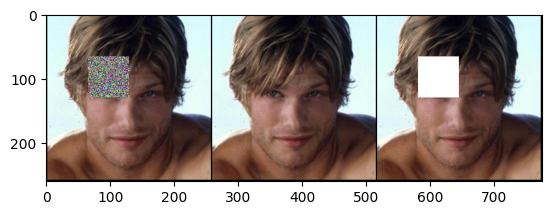

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image'], sample['mask_image']], padding=2)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True, drop_last=True
)

In [ ]:
len(train_loader)

843

## Training

In [ ]:
from torchcfm.models.unet import UNetModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
model

UNetModelWrapper(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [ ]:
n_epochs = int(1e4)

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

843it [05:17,  2.65it/s]


epoch: 0, loss: 0.00287


843it [05:23,  2.60it/s]


epoch: 1, loss: 0.002549


843it [06:22,  2.20it/s]


epoch: 2, loss: 0.002429


843it [05:13,  2.69it/s]


epoch: 3, loss: 0.002259


843it [05:11,  2.70it/s]


epoch: 4, loss: 0.00216


843it [05:13,  2.69it/s]


epoch: 5, loss: 0.002107


843it [05:12,  2.70it/s]


epoch: 6, loss: 0.002112


843it [05:12,  2.70it/s]


epoch: 7, loss: 0.002004


843it [05:02,  2.79it/s]


epoch: 8, loss: 0.001969


843it [05:02,  2.79it/s]


epoch: 9, loss: 0.001942


843it [05:02,  2.79it/s]


epoch: 10, loss: 0.001905


843it [05:02,  2.79it/s]


epoch: 11, loss: 0.001889


843it [05:02,  2.79it/s]


epoch: 12, loss: 0.001844


843it [05:01,  2.79it/s]


epoch: 13, loss: 0.0018


843it [05:01,  2.79it/s]


epoch: 14, loss: 0.00185


843it [05:02,  2.79it/s]


epoch: 15, loss: 0.001796


843it [05:02,  2.79it/s]


epoch: 16, loss: 0.001784


843it [05:01,  2.79it/s]


epoch: 17, loss: 0.001738


843it [05:02,  2.79it/s]


epoch: 18, loss: 0.001786


843it [05:01,  2.79it/s]


epoch: 19, loss: 0.001723


843it [05:02,  2.79it/s]


epoch: 20, loss: 0.001761


843it [05:01,  2.79it/s]


epoch: 21, loss: 0.001748


843it [05:02,  2.79it/s]


epoch: 22, loss: 0.001704


843it [05:02,  2.79it/s]


epoch: 23, loss: 0.001685


843it [05:02,  2.79it/s]


epoch: 24, loss: 0.001717


843it [05:01,  2.79it/s]


epoch: 25, loss: 0.001704


843it [05:01,  2.80it/s]


epoch: 26, loss: 0.001671


843it [05:01,  2.79it/s]


epoch: 27, loss: 0.001645


843it [05:02,  2.79it/s]


epoch: 28, loss: 0.001659


843it [05:02,  2.79it/s]


epoch: 29, loss: 0.001627


843it [05:02,  2.79it/s]


epoch: 30, loss: 0.001686


843it [05:02,  2.79it/s]


epoch: 31, loss: 0.001661


843it [05:02,  2.79it/s]


epoch: 32, loss: 0.001657


843it [05:04,  2.77it/s]


epoch: 33, loss: 0.001618


843it [05:17,  2.66it/s]


epoch: 34, loss: 0.00166


843it [05:13,  2.69it/s]


epoch: 35, loss: 0.001633


843it [05:27,  2.57it/s]


epoch: 36, loss: 0.001616


9it [00:05,  1.76it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1, )
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image*(1. - mask) + mask*y
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(val_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

In [ ]:
traj.shape, cond_image.shape

(torch.Size([50, 32, 3, 256, 256]), torch.Size([32, 3, 256, 256]))

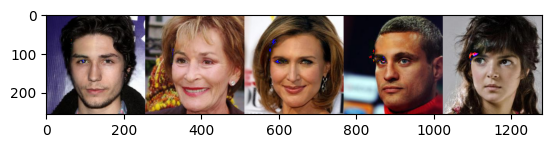

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

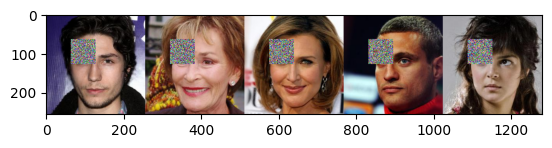

In [ ]:
grid = make_grid(
    cond_image[-5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
torch.save(model.state_dict(), "model_best.pth")